In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import hopsworks
import os

In [4]:
project = hopsworks.login(api_key_value=os.getenv("HOPSWORKS_PYTHON_CLIKEY"))
fs = project.get_feature_store()
fs

2025-03-08 23:24:02,462 INFO: Initializing external client
2025-03-08 23:24:02,463 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-08 23:24:03,074 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214673


In [5]:
try: 
    feature_view = fs.get_feature_view(name="iris", version=1)
except:
    iris_fg = fs.get_feature_group(name="iris", version=1)
    query = iris_fg.select_all()
    feature_view = fs.create_feature_view(
        name="iris",
        version=1,
        description="Read all of iris feature group",
        labels=["variety"],
        query=query
        )

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1214673/fs/1202301/fv/iris/version/1


In [6]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.40s) 


In [7]:
X_train

,sepal_length,sepal_width,petal_length,petal_width
0,5.7,3.8,1.7,0.3
2,6.3,3.3,6.0,2.5
4,5.0,3.0,1.6,0.2
5,6.4,2.9,4.3,1.3
7,6.3,3.3,4.7,1.6
...,...,...,...,...
144,5.8,2.6,4.0,1.2
145,6.2,2.8,4.8,1.8
146,6.5,3.0,5.5,1.8
147,6.4,2.8,5.6,2.1


In [11]:
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2)

In [12]:
y_pred = model.predict(X_test)
y_pred

array(['Versicolor', 'Versicolor', 'Virginica', 'Virginica', 'Versicolor',
       'Setosa', 'Versicolor', 'Setosa', 'Versicolor', 'Versicolor',
       'Virginica', 'Virginica', 'Setosa', 'Versicolor', 'Setosa',
       'Setosa', 'Setosa', 'Virginica', 'Versicolor', 'Setosa',
       'Versicolor', 'Versicolor', 'Versicolor', 'Setosa', 'Versicolor',
       'Setosa', 'Virginica', 'Setosa', 'Virginica', 'Setosa'],
      dtype=object)

In [13]:
metrics = classification_report(y_test, y_pred, output_dict=True)
print(metrics)

{'Setosa': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 11}, 'Versicolor': {'precision': 0.8333333333333334, 'recall': 1.0, 'f1-score': 0.9090909090909091, 'support': 10}, 'Virginica': {'precision': 1.0, 'recall': 0.7777777777777778, 'f1-score': 0.8750000000000001, 'support': 9}, 'accuracy': 0.9333333333333333, 'macro avg': {'precision': 0.9444444444444445, 'recall': 0.9259259259259259, 'f1-score': 0.9280303030303031, 'support': 30}, 'weighted avg': {'precision': 0.9444444444444445, 'recall': 0.9333333333333333, 'f1-score': 0.9321969696969696, 'support': 30}}


In [18]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[11  0  0]
 [ 0 10  0]
 [ 0  2  7]]


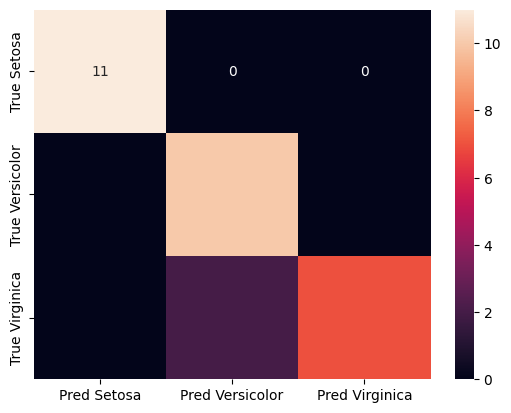

In [20]:
from matplotlib import pyplot

df_cm = pd.DataFrame(cf_matrix, ['True Setosa', 'True Versicolor', 'True Virginica'],
                     ['Pred Setosa', 'Pred Versicolor', 'Pred Virginica'])

cm = sns.heatmap(df_cm, annot=True)

fig = cm.get_figure()
fig.savefig("./assets/confusion_matrix.png") 
fig.show()

In [22]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import shutil

mr = project.get_model_registry()

joblib.dump(model, filename="./iris_model/model.pkl")
shutil.copyfile("./assets/confusion_matrix.png", "./iris_model/confusion_matrix.png")

input_example = X_train.sample()
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

iris_model = mr.python.create_model(
    version=1,
    name="iris",
    metrics={"accuracy": metrics['accuracy']},
    model_schema=model_schema,
    input_example=input_example,
    description="Iris flower predictor"
)

iris_model.save("./iris_model")

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/11844 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/16760 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/20 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/480 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1214673/models/iris/1


Model(name: 'iris', version: 1)